# Começa aqui o desafio proposto:

### Criar um modelo SVM para prever duas colunas de observações presente no banco de dados

###### O passso inicial para uma análise de dados é a leitura dos dados. O banco de dados fornecido foi salvo na pasta "Desktop" com o nome "desafio.csv".

In [1]:
setwd("C:/Users/lucia/Desktop")
desafio = read.csv2("desafio.csv")

library(caTools)
library(scatterplot3d) 
library(outliers)
library(caret)
library(ROSE)
library(stringr)
library(e1071)



Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Loaded ROSE 0.0-3

Warning message:
"package 'stringr' was built under R version 3.6.3"

###### Após a leitura dos dados é importante verificar o cabeçalho para definir as colunas que serão usadas na presente análise.

In [2]:
head(desafio)

FEATURE.6,FEATURE.5,FEATURE.4,FEATURE.1,FEATURE.2,FEATURE.3,Previsao.A,Previsao.B,X,X.1
03/01/2020,12:06:57,C021K13101,1180227,109B1L,10.060,0.955,BOM,NA,NA
03/01/2020,21:19:00,C021K13102,1180227,109B1L,10.052,0.955,BOM,NA,NA
04/01/2020,13:34:55,C021K14101,1180227,109B1L,10.040,0.955,BOM,NA,NA
04/01/2020,17:30:46,C021K14102,1180227,109B1M,10.028,0.955,BOM,NA,NA
04/01/2020,23:05:04,C021K14103,1180227,109B1M,10.067,0.955,BOM,NA,NA
05/01/2020,04:22:18,C021K15101,1180227,109B1M,10.080,0.956,BOM,NA,NA


###### O cabeçalho permitiu verificar que as três primeiras colunas se referem a identificação, como data, hora e uma coluna com dados que não se repetem, sendo assim considerados códigos únicos de cada observação, dessa forma sendo descartados no modelo.
###### Além destas três, as duas últimas colunas não apresentam valores, portanto serão excluídas.
###### Aqui, optei por criar um novo banco de dados que exclui as colunas 1, 2, 3, 9 e 10. Além disso, renomeei as colunas com nomes mais simplificados apenas para facilitar a manipulação dos dados.

In [3]:
dados = desafio[,c(-1,-2,-3,-9,-10)] #EXCLUIR COLUNAS VAZIAS e de identificação
colnames(dados) = c("F1","F2","F3","A","B") #RENOMEAR COLUNAS
head(dados)

F1,F2,F3,A,B
1180227,109B1L,10.060,0.955,BOM
1180227,109B1L,10.052,0.955,BOM
1180227,109B1L,10.040,0.955,BOM
1180227,109B1M,10.028,0.955,BOM
1180227,109B1M,10.067,0.955,BOM
1180227,109B1M,10.080,0.956,BOM


###### O banco de dados apresenta, então, 5 variáveis. Vamos analisá-las e identificar o que deve ser feito em cada uma.

In [4]:
table(dados$F1) # duas classes interpretáveis


        1180223 1180223/1180227         1180227 1180227/1180223 
            129               3              46               1 

###### Variável FEATURE.1 (F1) apresenta 4 classes. Duas delas são combinações das outras. Como não há legendas para o banco de dados e parece haver incoerência nestas classes, iremos descartá-las, substituindo seus valores por NA. Em seguida as outras classes serão transformadas em dummy onde 0 representa "1180223" e 1 representa "1180227". De outra forma, é uma dummy para "1180227", onde 1 significa presença dessa característica e 0 a ausência. Por fim é importante transformá-la em variável numérica.

In [5]:
library(stringr)
### transformar em NA dados sem interpretação
dados$F1 = str_replace(dados$F1,"[0-9]+/[0-9]+","NA")
### criar dummy
dados$F1 = (str_replace(dados$F1,"1180223","0"))
dados$F1 = (str_replace(dados$F1,"1180227","1"))
###transformar em numérica
dados$F1 = as.numeric(dados$F1) #aviso de correção de string "NA" para NA como dado faltante

Warning message in eval(expr, envir, enclos):
"NAs introduzidos por coerção"

###### Após realizada a transformação anterior, a coluna passou a apresentar alguns dados faltantes. Há diversas formas de tratar estes dados, aqui optei por retirar as linhas do banco de dados pois são apenas 4 NA produzidos. Em outros casos, porém, não é aconselhável a retirada tendo que optar por outras maneiras de tratamento.

In [6]:
linhas = NULL
for( i in 1:nrow(dados)){
  if(is.na(dados$F1[i])){
    linhas=c(linhas,i)
  }
}
dados = dados[-linhas,]
linhas = NULL
table(dados$F1)


  0   1 
129  46 

Uma vez tratada a primeira coluna, nota-se que apresenta apenas os valores 0 e 1 conforme o desejado.

##### Vamos agora visualizar a segunda coluna, através da tabela contendo seus dados.

In [7]:
#### F2
table(dados$F2) #duas classes, criar dummy


109B1L 109B1M 
    56    119 

##### Essa coluna apresenta duas categorias, portanto pode ser transformada em dummy e posteriormente em dados numéricos.

In [8]:
dados$F2 = str_replace(dados$F2,"109B1L","0")
dados$F2 = str_replace(dados$F2,"109B1M","1")
dados$F2 = as.numeric(dados$F2)


##### A terceira coluna, F3, apresenta dados numéricos conforme visualizado na tabela a seguir.

In [9]:
#### F3
table(dados$F3) #variável numérica, retirar "." e transformar em numérico


10.000 10.001 10.002 10.003 10.004 10.005 10.006 10.007 10.009 10.010 10.011 
     4      3      1      3      1      2      1      1      2     13      2 
10.012 10.013 10.014 10.016 10.020 10.024 10.025 10.028 10.029 10.030 10.031 
     5      2      1      1      6      1      1      1      2      1      1 
10.032 10.034 10.035 10.036 10.037 10.038 10.039 10.040 10.041 10.042 10.045 
     1      1      2      2      1      1      1     12      2      3      1 
10.047 10.048 10.049 10.050 10.051 10.052 10.053 10.054 10.055 10.056 10.057 
     2      2      1     13      3      5      2      2      2      4      1 
10.059 10.060 10.061 10.062 10.063 10.065 10.067 10.069 10.070 10.072 10.073 
     2     13      2      2      2      1      2      2      3      1      5 
10.074 10.078 10.080 10.090 10.750  9.976  9.980  9.981  9.983  9.990  9.993 
     3      1      4      1      1      1      1      1      1      2      2 
 9.994  9.997  9.999 
     1      1      1 

##### Estes dados numéricos estão separados por "." que simboliza a casa de milhar. É importante retirar esses pontos e transformar a variável em numérica.

In [10]:
dados$F3 =dados$F3 %>%  str_remove("[.]") %>% as.numeric()

##### Antes de passar para próxima coluna, um gráfico dos dados é importante para visualizar a distribuição destes e definir se há outlier que possa interferir nas modelagens futuras. Gráfico de dispersão e boxplot são indicados.

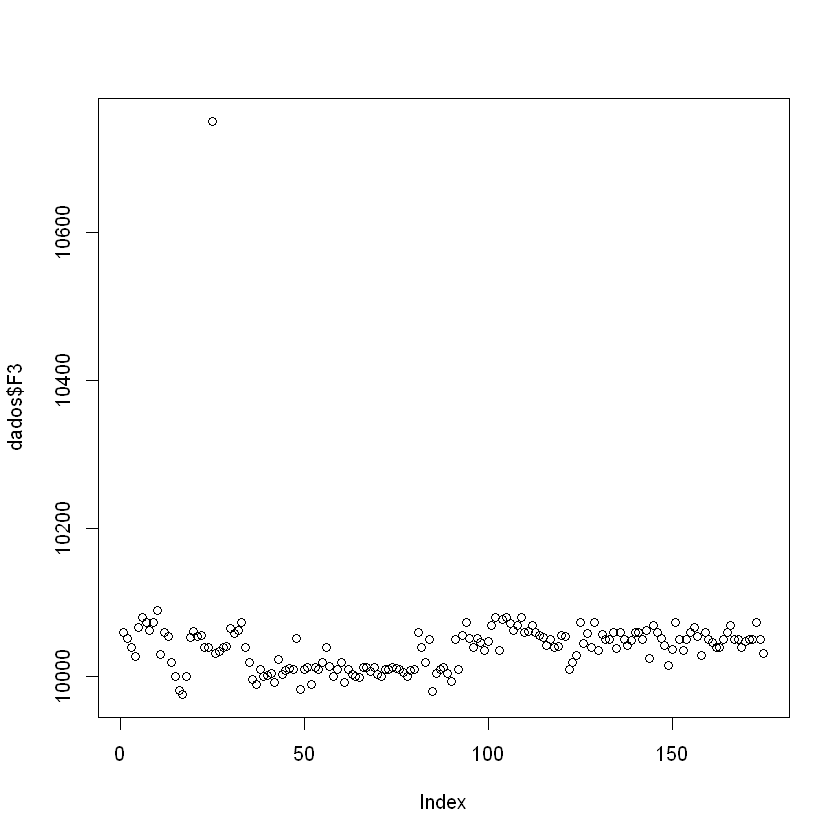

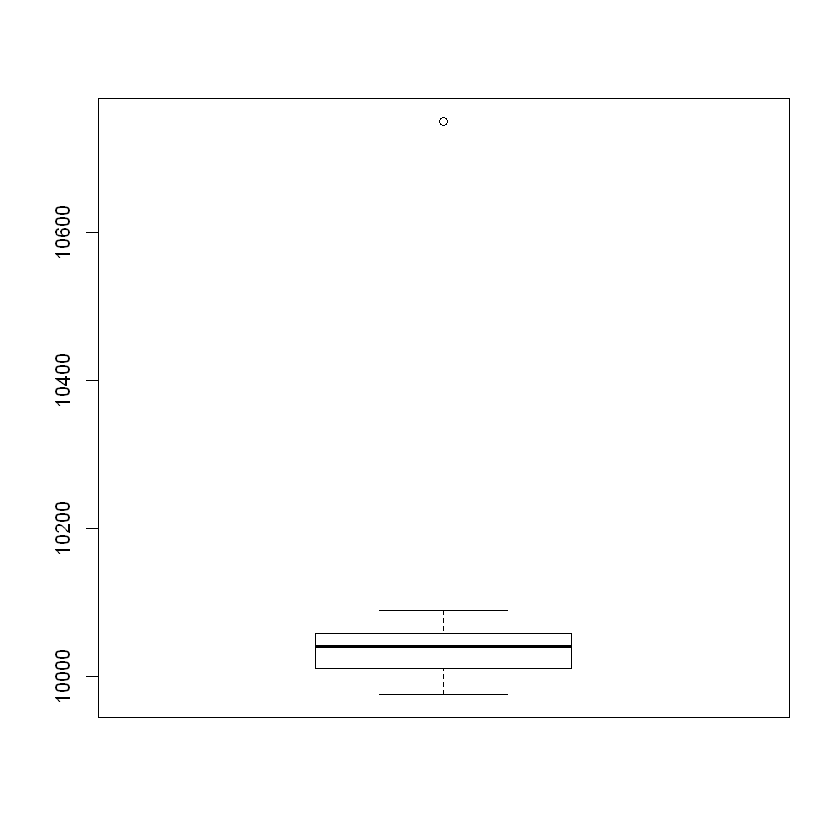

In [11]:
plot(dados$F3);boxplot(dados$F3)#RETIRAR OUTLIER

##### Os gráficos apontaram a presença de outlier, deve-se retirá-lo. Para tal, vamos transformá-lo em NA e excluir da base de dados a linha que contém o NA.

In [12]:
library(outliers) #pacote para verificas outliers

out = outlier(dados$F3)  #detectando NA
dados$F3 = ifelse(dados$F3==out,'NA',dados$F3) #substituindo outlier por NA
dados$F3 = as.numeric(dados$F3) 

#verificar linhas com NA
linhas = NULL
for( i in 1:nrow(dados)){
  if(is.na(dados$F3[i])){
    linhas=c(linhas,i)
  }
}
#retirar linhas com NA do banco de dados
dados = dados[-linhas,]
linhas = NULL

Warning message in eval(expr, envir, enclos):
"NAs introduzidos por coerção"

##### Analisando a coluna da Previsao.A, transformando-a em numérica.

In [13]:
dados$A = as.numeric(dados$A)

##### A coluna da Previsao.B deve ser tratada como um fator.

In [14]:
dados$B = factor(dados$B, levels = c("BOM","RUIM"))

###### Por fim, a estrutura do banco de dados é dada por:

In [15]:
str(dados)

'data.frame':	174 obs. of  5 variables:
 $ F1: num  1 1 1 1 1 1 1 1 1 0 ...
 $ F2: num  0 0 0 1 1 1 1 0 0 1 ...
 $ F3: num  10060 10052 10040 10028 10067 ...
 $ A : num  0.955 0.955 0.955 0.955 0.955 0.956 0.955 0.956 0.955 0.955 ...
 $ B : Factor w/ 2 levels "BOM","RUIM": 1 1 1 1 1 1 1 1 1 1 ...


###### O banco de dados é composto por quatro variáveis numéricas, sendo duas dummies e uma variável fator.


###### O gráfico abaixo é uma forma de visualizar de forma tridimensional a distribuição dos dados


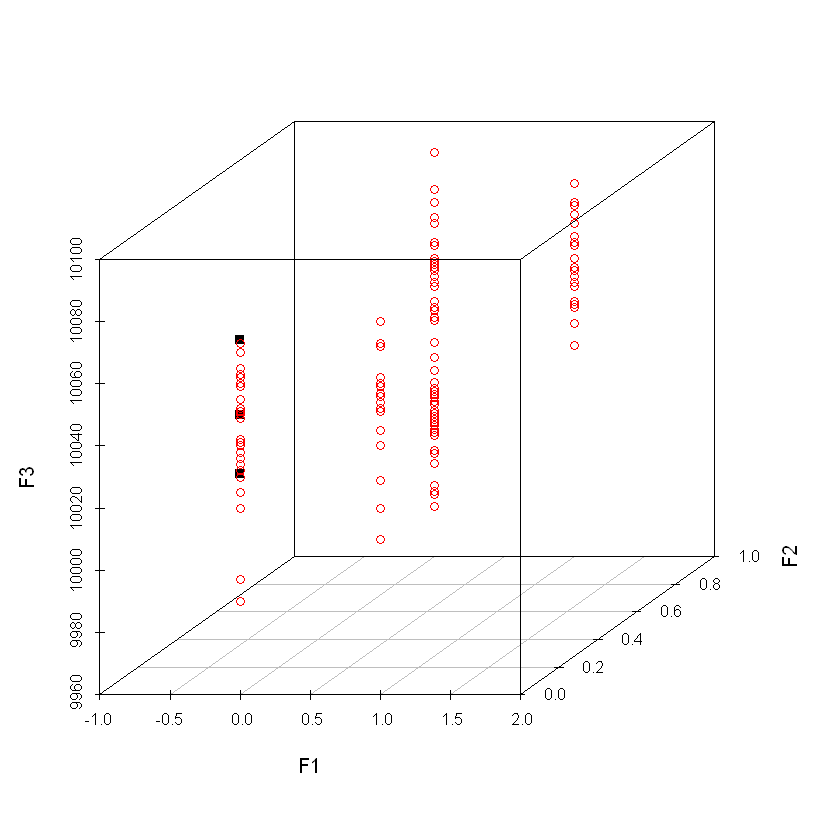

In [16]:
library(scatterplot3d) #pacote para gráfico 3D
cores = c("red", "black")
cores = cores[as.numeric(dados$B)] 
pch  = ifelse(cores==cores[1],1,15)
scatterplot3d(dados[,1:3],pch = pch,  color=cores,xlim = c(-1,2),ylim = c(0,1))


###### Na cor preta encontram-se as observções do fator "RUIM", em vermelhos as classificadas como "BOM".

##### Além do gráfico, é importante construir as tabelas de distribuição de frequências absolutas e relativas das variáveis F1 e F2

In [17]:
#tabelas
table(dados$F1)
round(prop.table(table(dados$F1))*100,2)

table(dados$F2)
round(prop.table(table(dados$F2))*100,2)



  0   1 
128  46 


    0     1 
73.56 26.44 


  0   1 
 55 119 


    0     1 
31.61 68.39 

##### Os gráficos de dispersão e histograma da FEATURE 3 são importantes para viasualização da distribuição desses dados. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9976   10011   10040   10037   10058   10090 

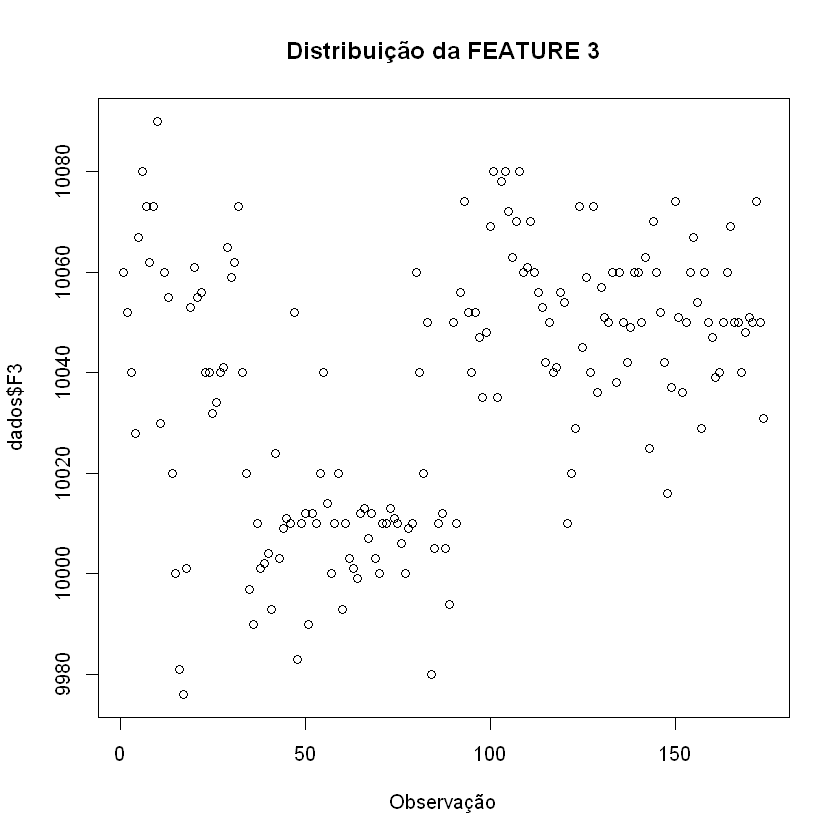

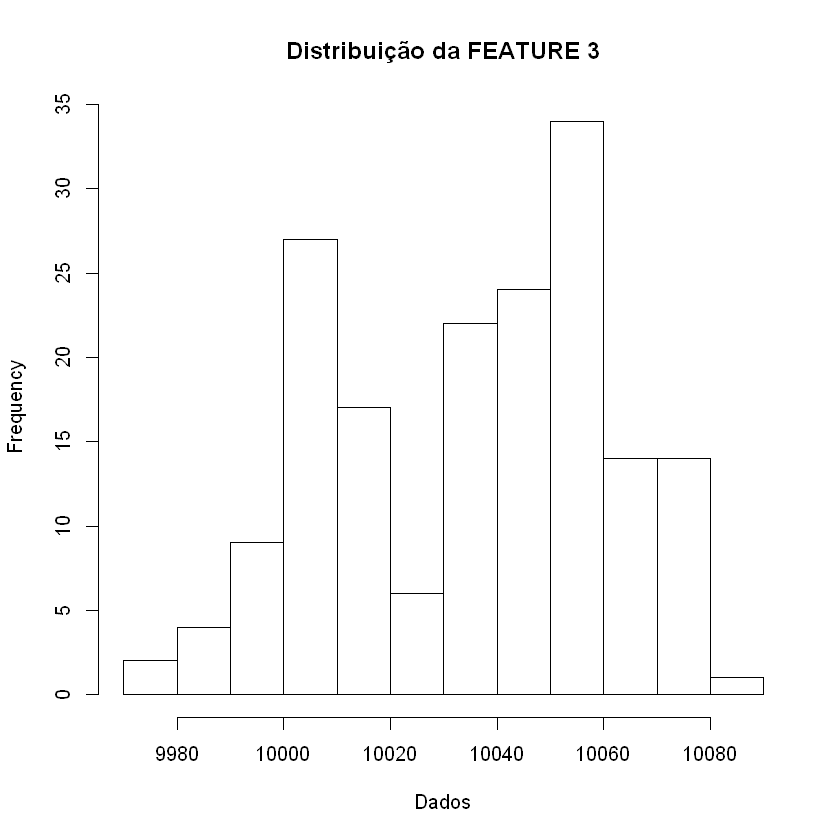

In [18]:
summary(dados$F3)
plot(dados$F3, main="Distribuição da FEATURE 3",xlab="Observação")
hist(dados$F3, main="Distribuição da FEATURE 3",xlab="Dados")

###### Vamos analisar agora as variáveis de previsão. Apesar de se tratar de variável numérica, os dados da previsão A estão distribuídos entre quatro números apenas, conforme pode ser visto abaixo


0.954 0.955 0.956 0.961 
   22   140    11     1 

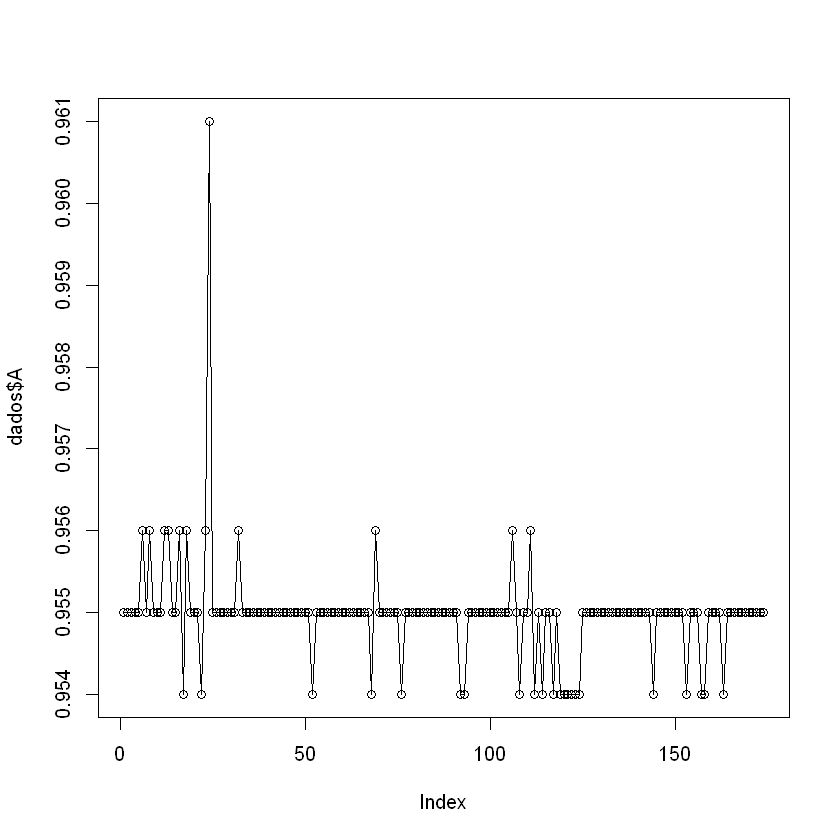

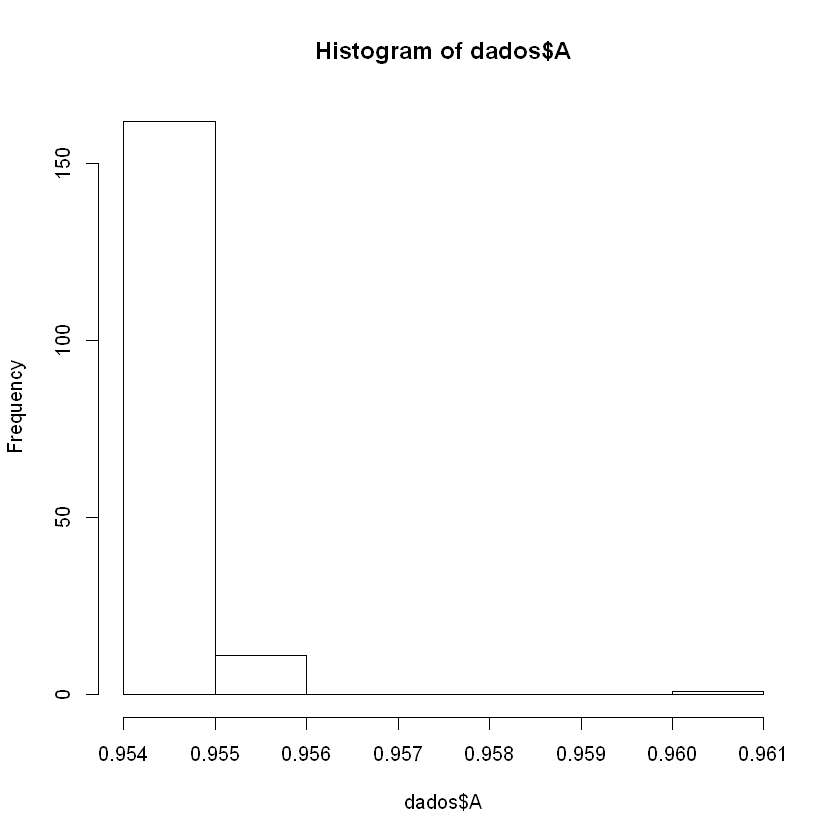

In [19]:
table(dados$A)
plot(dados$A)
lines(dados$A)
hist(dados$A)

##### A análise da previsão B pode ser feita através de uma tabela com distribuição absoluta e relativa, bem como um gráfico para melhor visualização.


 BOM RUIM 
 170    4 


 BOM RUIM 
97.7  2.3 

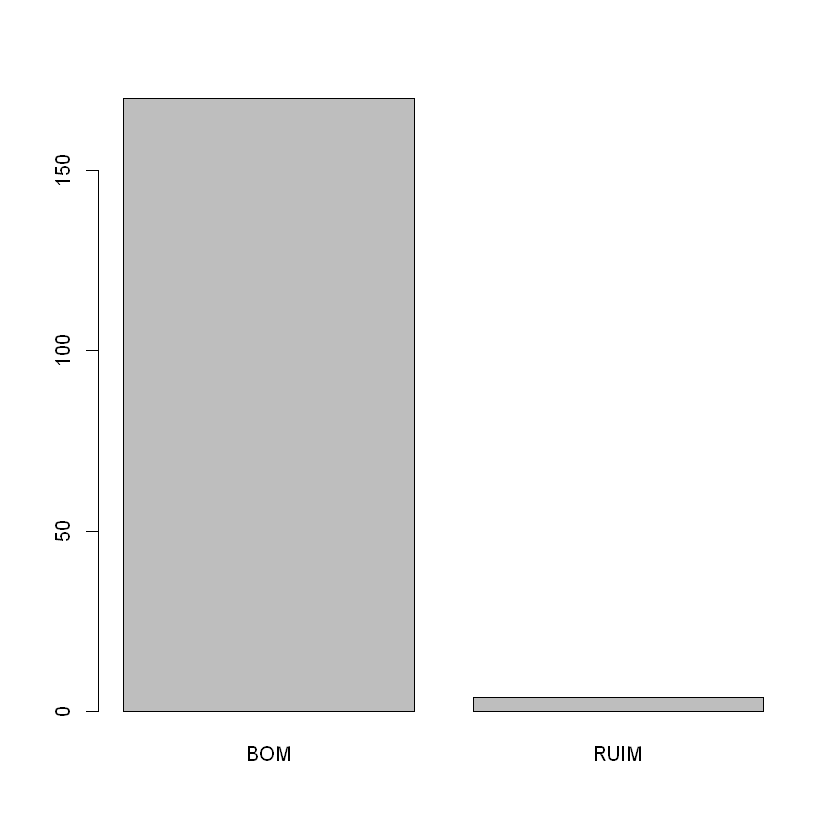

In [20]:
table(dados$B) 
round(prop.table(table(dados$B))*100,2) #dados precisam ser balanceados
plot(dados$B)

A análise descritiva por meio de tabelas e gráficos é essencial no pré processamento de qualquer banco de dados.

##### Todo algoritmo de treinamento se inicia pela divisão do banco de dados. O treinamento será feito com 80% dos dados e a base de teste constitui os 20% restantes. Por se tratar de uma escolha aleatória pelo algoritmo, é importante fixar a semente de repetição afim de sempre obter a mesma amostra.

In [21]:
library(caTools) #pacote da função 

#dividindo conjunto em treino e teste
set.seed(1) #semente
divisao = sample.split(dados$B, SplitRatio = 0.8) 
base_treinamento = subset(dados, divisao == TRUE) #80% para treinamento
base_teste = subset(dados, divisao == FALSE) # o restante para teste


##### A análise descritiva já trouxe um indício de que é necesário balancear os dados, porém vamos realizar a modelagem sem fazê-lo afim de entender o que acontece no treinamento.

In [22]:
############################################### 
#        TESTAR DADOS SEM BALANCEAR           #
###############################################
library("e1071")
classificador1 = svm(formula = B ~ .,
                    data = dados[,-4],
                    type = "C-classification",
                    kernel = "radial",
                    cost = 500)

classificador1


Call:
svm(formula = B ~ ., data = dados[, -4], type = "C-classification", 
    kernel = "radial", cost = 500)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  500 
      gamma:  0.3333333 

Number of Support Vectors:  19


##### Após definido o classificador, podemos calcular a previsão e a matriz de confusão que relaciona os dados de teste com a previsão.

In [23]:
library(caret) #pacote para usar função confusionMatrix()
library (lattice)

previsao1 = predict(classificador1, newdata = base_teste[c(1:3)])
matriz_confusao1 = table(base_teste[,5],previsao1)
confusionMatrix(matriz_confusao1)


Confusion Matrix and Statistics

      previsao1
       BOM RUIM
  BOM   34    0
  RUIM   1    0
                                          
               Accuracy : 0.9714          
                 95% CI : (0.8508, 0.9993)
    No Information Rate : 1               
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9714          
            Specificity :     NA          
         Pos Pred Value :     NA          
         Neg Pred Value :     NA          
             Prevalence : 1.0000          
         Detection Rate : 0.9714          
   Detection Prevalence : 0.9714          
      Balanced Accuracy :     NA          
                                          
       'Positive' Class : BOM             
                                          

##### A previsão retornou acurácia de 97,14%. Esse número, observado de forma isolada, parece ser bom, porém uma análise ampla demonstra que o classificador não previu o item RUIM. Isto pode significar enorme prejuízo. É a demonstração de que os dados devem ser balanceados.

#### O balanceamento consiste em equilibrar a proporção de observações em cada classe. A coluna de previsao B apresenta proporção aproximada de 98:2. Quando dividido no banco de testes, apenas uma observação é RUIM, então o classificador erra nessa previsão. Várias são as possibilidades de balancear os dados. Aqui, optei por realizarr sobreamostragem na classe minoritária e subamostragem na majoritária. Isso quer dizer que na classe com menos observações, RUIM, é realizada diversas amostragens afim de aumentar a quantidade de informações. Já na classe majoritária é realizada uma amostragem afim de diminuir seus dados até chegar numa proporção definida.

In [24]:
##################################### 
#        BALANCEAR CLASSE           #
#####################################
library(ROSE)
B_balanceado <- ovun.sample(B ~ ., data = base_treinamento[-4], 
                            method = "both", p=0.5,
                            N = 136*1.8, seed=1)$data

table(B_balanceado$B)
round(prop.table(table(B_balanceado$B))*100,2)



 BOM RUIM 
 121  123 


  BOM  RUIM 
49.59 50.41 

##### Uma vez que os dados foram balanceados é possível construir SVM. A fómula utiliza a previsão B como variável dependente e as três F1, F2 e F3 como preditoras. O tipo usado foi classificação. O primeiro kernel "radial", mas outros serão testados.

In [25]:
##################################### 
#              PREVISÃO B           #
#####################################

classificadorB = svm(formula = B ~ .,
                    data = B_balanceado,
                    type = "C-classification",
                    kernel = "radial")

In [26]:
#Após realizar a classificação na base de treinamento balaceada, é possível realizar as previsões desejadas

previsaoB = predict(classificadorB, newdata = base_teste[c(1:3)])
table(previsaoB)

previsaoB
 BOM RUIM 
  31    4 

##### Com os dados de previstos, é aconselhável  criar uma matriz de confusao, ou tabela de contigência, com intuito de comparar os dados previstos e os valores de testes. Em seguida pode-se medir a acurácia da previsão.

In [27]:
matriz_confusaoB = table(base_teste[,5],previsaoB)
confusionMatrix(matriz_confusaoB)


Confusion Matrix and Statistics

      previsaoB
       BOM RUIM
  BOM   31    3
  RUIM   0    1
                                         
               Accuracy : 0.9143         
                 95% CI : (0.7694, 0.982)
    No Information Rate : 0.8857         
    P-Value [Acc > NIR] : 0.4216         
                                         
                  Kappa : 0.3713         
                                         
 Mcnemar's Test P-Value : 0.2482         
                                         
            Sensitivity : 1.0000         
            Specificity : 0.2500         
         Pos Pred Value : 0.9118         
         Neg Pred Value : 1.0000         
             Prevalence : 0.8857         
         Detection Rate : 0.8857         
   Detection Prevalence : 0.9714         
      Balanced Accuracy : 0.6250         
                                         
       'Positive' Class : BOM            
                                         

##### Como desejado, o svm previu corretamente a observação RUIM. Em três previsões, RUIM foi classificado erroneamente, porém, espera-se que este erro não cause grandes prejuízos, sendo considerado um falso negativo de menor impacto. Nesses casos, uma análise do problema estudado é essecial. Há casos em que o custo de determinados erros é muito alto e isto deve ser lavado em conta. Apesar da acurácia desta previsão ser menor quando comparada à previsão sem realização do balanceamento, o erro de não prever a custoso do que classificar como RUIM algumas observações que são BOM.


#### Outro fator importante é a escolha da função kernel para treinamento da SVM. A primeira testada foi a "radial", porém iremmos testar as demais funções disponíveis no pacote.

In [28]:
#kernel linear
classificadorB.linear = svm(formula = B ~ .,
                     data = B_balanceado,
                     type = "C-classification",
                     kernel = "linear",
                     cost = 500)
previsaoB.linear = predict(classificadorB.linear, newdata = base_teste[c(1:3)])
matriz_confusaoB.linear = table(base_teste[,5],previsaoB.linear)
confusionMatrix(matriz_confusaoB.linear)


Confusion Matrix and Statistics

      previsaoB.linear
       BOM RUIM
  BOM   30    4
  RUIM   0    1
                                         
               Accuracy : 0.8857         
                 95% CI : (0.7326, 0.968)
    No Information Rate : 0.8571         
    P-Value [Acc > NIR] : 0.4269         
                                         
                  Kappa : 0.3            
                                         
 Mcnemar's Test P-Value : 0.1336         
                                         
            Sensitivity : 1.0000         
            Specificity : 0.2000         
         Pos Pred Value : 0.8824         
         Neg Pred Value : 1.0000         
             Prevalence : 0.8571         
         Detection Rate : 0.8571         
   Detection Prevalence : 0.9714         
      Balanced Accuracy : 0.6000         
                                         
       'Positive' Class : BOM            
                                         

In [29]:
#kernel polynomial
classificadorB.polynomial = svm(formula = B ~ .,
                            data = B_balanceado,
                            type = "C-classification",
                            kernel = "polynomial",
                            cost = 500)
previsaoB.polynomial = predict(classificadorB.polynomial, newdata = base_teste[c(1:3)])
matriz_confusaoB.polynomial = table(base_teste[,5],previsaoB.polynomial)
confusionMatrix(matriz_confusaoB.polynomial)


Confusion Matrix and Statistics

      previsaoB.polynomial
       BOM RUIM
  BOM   30    4
  RUIM   0    1
                                         
               Accuracy : 0.8857         
                 95% CI : (0.7326, 0.968)
    No Information Rate : 0.8571         
    P-Value [Acc > NIR] : 0.4269         
                                         
                  Kappa : 0.3            
                                         
 Mcnemar's Test P-Value : 0.1336         
                                         
            Sensitivity : 1.0000         
            Specificity : 0.2000         
         Pos Pred Value : 0.8824         
         Neg Pred Value : 1.0000         
             Prevalence : 0.8571         
         Detection Rate : 0.8571         
   Detection Prevalence : 0.9714         
      Balanced Accuracy : 0.6000         
                                         
       'Positive' Class : BOM            
                                         

In [30]:
#kernel sigmoid
classificadorB.sigmoid = svm(formula = B ~ .,
                                data = B_balanceado,
                                type = "C-classification",
                                kernel = "sigmoid",
                                cost = 500)
previsaoB.sigmoid = predict(classificadorB.sigmoid, newdata = base_teste[c(1:3)])
matriz_confusaoB.sigmoid = table(base_teste[,5],previsaoB.sigmoid)
confusionMatrix(matriz_confusaoB.sigmoid)

Confusion Matrix and Statistics

      previsaoB.sigmoid
       BOM RUIM
  BOM   29    5
  RUIM   0    1
                                          
               Accuracy : 0.8571          
                 95% CI : (0.6974, 0.9519)
    No Information Rate : 0.8286          
    P-Value [Acc > NIR] : 0.43040         
                                          
                  Kappa : 0.2489          
                                          
 Mcnemar's Test P-Value : 0.07364         
                                          
            Sensitivity : 1.0000          
            Specificity : 0.1667          
         Pos Pred Value : 0.8529          
         Neg Pred Value : 1.0000          
             Prevalence : 0.8286          
         Detection Rate : 0.8286          
   Detection Prevalence : 0.9714          
      Balanced Accuracy : 0.5833          
                                          
       'Positive' Class : BOM             
                                   

#### Pode-se concluir que para o banco de dados testado, a função kernel mais indicado é radial, uma vez que apresentou maior acurácia. 

#### Para o classificador utilizado para a previsão A, os mesmos passos são seguidos.

In [31]:
##################################### 
#              PREVISÃO A           #
#####################################
classificadorA = svm(formula = A ~ .,
                    data = base_treinamento[1:4],
                    kernel="radial")
              



In [32]:
previsaoA = predict(classificadorA, newdata = base_teste[1:3])
previsaoA
prev =  round(previsaoA,3)



4         6         7        20        22        23        32        38 
0.9549314 0.9549312 0.9549321 0.9550053 0.9549324 0.9549324 0.9550620 0.9549355 
       40        44        46        49        55        64        73        75 
0.9549827 0.9550170 0.9550009 0.9549827 0.9549772 0.9549827 0.9550074 0.9549827 
       79        80        82        83        98        99       100       103 
0.9549934 0.9550074 0.9549827 0.9549324 0.9549327 0.9549330 0.9549327 0.9549329 
      108       114       116       126       140       144       155       167 
0.9549023 0.9549324 0.9549323 0.9545808 0.9550674 0.9550674 0.9549323 0.9549335 
      169       170       178 
0.9549324 0.9549324 0.9550657

In [33]:
cat("Base de teste")
table(base_teste[,4])

cat("\nPrevisão")
table(prev)

Base de teste


0.954 0.955 0.956 
    3    29     3 


Previsão

prev
0.955 
   35 

In [34]:
matriz_confusaoA = table( base_teste[,4] , round(previsaoA,3))
matriz_confusaoA

       
        0.955
  0.954     3
  0.955    29
  0.956     3

#### Apesar de se tratar de dados numéricos e as previsões apresentarem diversas casas decimais, quando realizado o arredondamento construída a matriz de confusão, foi possível notar que todas os valores previstos são aproximadamente 0.955. Entende-se que esta não é uma boa previsão, portanto é necessário realizar o balanceamento dos dados.

In [35]:
table(base_treinamento[,4])


0.954 0.955 0.956 0.961 
   19   111     8     1 

##### Os dados da base de treinamento estão distribuídos em quatro valore, sendo o "0.961" apresentando apenas uma observação, portanto será desconsiderado. Os outros valores serão dividos em pares contendo a classe majoritária afim de realizar subamostragem e sobreamostragem com intuito de equilibrar a classe.

In [36]:
set.seed(1)
A_balanceado54 <- ovun.sample(as.factor(A) ~ ., data =subset(base_treinamento[,-5],A==0.954|A==0.955), 
                            method = "both", p=0.6,
                            N = 50*1.8, seed=1)$data
A_balanceado56 <- ovun.sample(as.factor(A) ~ ., data =subset(base_treinamento[,-5],A==0.956|A==0.955), 
                              method = "both", p=0.6,
                              N = 50*1.5, seed=1)$data
A_balaceado = merge(A_balanceado54,A_balanceado56,all = T)
prop.table(table(A_balaceado$A))

A_balaceado$A = as.numeric(A_balaceado$A) 


    0.954     0.955     0.956 
0.3028571 0.4400000 0.2571429 

#### Após realizar o balanceamento, pode-se seguir os passos para construção do SVM.

In [37]:
classificadorA = svm(formula = A ~ .,
                     data = A_balaceado[1:4],
                     kernel="radial")
previsaoA = predict(classificadorA, newdata = base_teste[1:3])
previsaoA = round(previsaoA,3)
matriz_confusaoA = table(base_teste[,4],previsaoA)
confusionMatrix(matriz_confusaoA)

Confusion Matrix and Statistics

       previsaoA
        0.954 0.955 0.956
  0.954     1     2     0
  0.955    13    12     4
  0.956     0     3     0

Overall Statistics
                                          
               Accuracy : 0.3714          
                 95% CI : (0.2147, 0.5508)
    No Information Rate : 0.4857          
    P-Value [Acc > NIR] : 0.9369          
                                          
                  Kappa : -0.1357         
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0.954 Class: 0.955 Class: 0.956
Sensitivity               0.07143      0.70588      0.00000
Specificity               0.90476      0.05556      0.90323
Pos Pred Value            0.33333      0.41379      0.00000
Neg Pred Value            0.59375      0.16667      0.87500
Prevalence                0.40000      0.48571      0.11429
Detection Rate            0.02857      0.34286      0.00

#### O mesmo será feito para diferentes tipos de função  kernel.

In [38]:
classificadorA.linear = svm(formula = A ~ .,
                     data = A_balaceado[1:4],
                     kernel="linear")
previsaoA.linear = predict(classificadorA.linear, newdata = base_teste[1:3])
previsaoA.linear = round(previsaoA.linear,3)
matriz_confusaoA.linear = table(base_teste[,4],previsaoA.linear)
matriz_confusaoA.linear

       previsaoA.linear
        0.954 0.955
  0.954     1     2
  0.955     8    21
  0.956     2     1

In [39]:
classificadorA.polynomial = svm(formula = A ~ .,
                            data = A_balaceado[1:4],
                            kernel="polynomial")
previsaoA.polynomial = predict(classificadorA.polynomial, newdata = base_teste[1:3])
previsaoA.polynomial = round(previsaoA.polynomial,3)
matriz_confusaoA.polynomial = table(base_teste[,4],previsaoA.polynomial)
confusionMatrix(matriz_confusaoA.polynomial)

Confusion Matrix and Statistics

       previsaoA.polynomial
        0.954 0.955 0.956
  0.954     1     2     0
  0.955     5    21     3
  0.956     0     3     0

Overall Statistics
                                          
               Accuracy : 0.6286          
                 95% CI : (0.4492, 0.7853)
    No Information Rate : 0.7429          
    P-Value [Acc > NIR] : 0.9547          
                                          
                  Kappa : -0.0248         
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0.954 Class: 0.955 Class: 0.956
Sensitivity               0.16667       0.8077      0.00000
Specificity               0.93103       0.1111      0.90625
Pos Pred Value            0.33333       0.7241      0.00000
Neg Pred Value            0.84375       0.1667      0.90625
Prevalence                0.17143       0.7429      0.08571
Detection Rate            0.02857       0.600

In [40]:

classificadorA.sigmoid = svm(formula = A ~ .,
                            data = A_balaceado[1:4],
                            kernel="sigmoid")
previsaoA.sigmoid = predict(classificadorA.sigmoid, newdata = base_teste[1:3])
previsaoA.sigmoid = round(previsaoA.sigmoid,3)
(matriz_confusaoA.sigmoid = table(base_teste[,4],previsaoA.sigmoid))

       previsaoA.sigmoid
        0.952 0.953 0.954 0.955 0.956 0.957 0.963 0.965 0.969
  0.954     0     0     0     2     0     0     0     1     0
  0.955     4     1     7    11     3     1     1     0     1
  0.956     2     0     1     0     0     0     0     0     0

##### Para os dados da Previsão A, o critério de decisão do melhor modelo de previsão deverá levar em consideração qual dos valores está disposto a errar mais. 

# COMENTÁRIOS FINAIS

### O teste passado consistia em construir um modelo pré determinado para previsão de dados categóricos e numéricos. A análise se iniciou pelo verificação de cada variável pertencente ao banco de dados. Em seguida, uma análise descritiva demonstrou a necessidade de tratamento, redefinindo variáveis e realizando balanceamento dos dados. Por fim foi realizado o método de classificação para então realizar as previsões. É importante frisar que em qualquer análise deve-se entender as componentes bem como o problema a ser resolvido. Números por si só nada refletem se não houver uma contextualização do problema envolvido.

## LUCIANA CAVALCANTE GUALBERTO
